In [1]:
import os
import tempfile
import warnings
from os.path import join as pjoin

import dask
import dask.dataframe as dd
import dask_geopandas as dgpd
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from scipy.fft import dst
import tqdm
import xarray as xr
from dask.diagnostics import ProgressBar
from rasterio.crs import CRS

from raster_tools import Raster, Vector, open_vectors, clipping, zonal
from raster_tools.dtypes import F32, U8

import matplotlib.pyplot as plt

In [2]:
# change pandas max col display
pd.set_option('display.max_columns', 500)

In [3]:
# Location for temporary storage
TMP_LOC = "/home/jake/FireLab/Project/data/temp/"
DATA_LOC = "/home/jake/FireLab/Project/data/"

STATE = "OR"

# Location of clipped DEM files
DEM_DATA_DIR = pjoin(TMP_LOC, "dem_data")

# location of feature data files
FEATURE_DIR = pjoin(DATA_LOC, "FeatureData")
EDNA_DIR = pjoin(DATA_LOC, "terrain")
MTBS_DIR = pjoin(DATA_LOC, "MTBS_Data")

mtbs_df_path = pjoin(TMP_LOC, f"{STATE}_mtbs.parquet")
mtbs_df_temp_path = pjoin(TMP_LOC, f"{STATE}_mtbs_temp.parquet")
checkpoint_1_path = pjoin(TMP_LOC, "check1")
checkpoint_2_path = pjoin(TMP_LOC, "check2")

PATHS = {
    "states": pjoin(EDNA_DIR, "state_borders/cb_2018_us_state_5m.shp"),
    "dem": pjoin(EDNA_DIR, "us_orig_dem/us_orig_dem/orig_dem/hdr.adf"),
    "dem_slope": pjoin(EDNA_DIR, "us_slope/us_slope/slope/hdr.adf"),
    "dem_aspect": pjoin(EDNA_DIR, "us_aspect/aspect/hdr.adf"),
    "dem_flow_acc": pjoin(EDNA_DIR, "us_flow_acc/us_flow_acc/flow_acc/hdr.adf"),
    "gm_srad": pjoin(FEATURE_DIR, "gridmet/srad_1986_2020_weekly.nc"),
    "gm_vpd": pjoin(FEATURE_DIR, "gridmet/vpd_1986_2020_weekly.nc"),
    "aw_mat": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MAT.tif"),
    "aw_mcmt": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MCMT.tif"),
    "aw_mwmt": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MWMT.tif"),
    "aw_td": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_TD.tif"),
    "dm_tmax": pjoin(FEATURE_DIR, "daymet/tmax_1986_2020.nc"),
    "dm_tmin": pjoin(FEATURE_DIR, "daymet/tmin_1986_2020.nc"),
    "biomass_afg": pjoin(
        FEATURE_DIR, "biomass/biomass_afg_1986_2020_{}.nc".format(STATE)
    ),
    "biomass_pfg": pjoin(
        FEATURE_DIR, "biomass/biomass_pfg_1986_2020_{}.nc".format(STATE)
    ),
    "landfire_fvt": pjoin(
        FEATURE_DIR, "landfire/LF2020_FVT_200_CONUS/Tif/LC20_FVT_200.tif"
    ),
    "landfire_fbfm40": pjoin(
        FEATURE_DIR, "landfire/LF2020_FBFM40_200_CONUS/Tif/LC20_F40_200.tif"
    ),
    "ndvi": pjoin(FEATURE_DIR, "ndvi/access/weekly/ndvi_1986_2020_weekavg.nc"),
    "mtbs_root": pjoin(MTBS_DIR, "MTBS_BSmosaics/"),
    "mtbs_perim": pjoin(MTBS_DIR, "mtbs_perimeter_data/mtbs_perims_DD.shp"),
}
YEARS = list(range(1986, 2021))
GM_KEYS = list(filter(lambda x: x.startswith("gm_"), PATHS))
AW_KEYS = list(filter(lambda x: x.startswith("aw_"), PATHS))
DM_KEYS = list(filter(lambda x: x.startswith("dm_"), PATHS))
BIOMASS_KEYS = list(filter(lambda x: x.startswith("biomass_"), PATHS))
LANDFIRE_KEYS = list(filter(lambda x: x.startswith("landfire_"), PATHS))
NDVI_KEYS = list(filter(lambda x: x.startswith("ndvi"), PATHS))
DEM_KEYS = list(filter(lambda x: x.startswith("dem"), PATHS))

---

## MTBS DATASET INFO

In [4]:
df = dgpd.read_parquet(mtbs_df_temp_path)
df.head()

,mtbs,geometry,state,ig_date,dem,dem_slope,dem_aspect,dem_flow_acc,dm_tmax,dm_tmin,biomass_afg,biomass_pfg,gm_srad,gm_vpd,ndvi,aw_mat,aw_mcmt,aw_mwmt,aw_td,landfire_fvt,landfire_fbfm40,hillshade,year
0,2,POINT (-1830990.000 2456610.000),OR,1986-03-20,1261.0,0.559452,305.295502,0.0,-3.049677,-16.621613,165.0,891.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2967.0,102.0,76,1986
1,2,POINT (-1830960.000 2456610.000),OR,1986-03-20,1277.0,2.485488,128.388641,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2967.0,102.0,187,1986
2,2,POINT (-1830990.000 2456580.000),OR,1986-03-20,1409.0,10.548834,277.054626,6.0,-3.049677,-16.621613,388.0,508.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2967.0,102.0,133,1986
3,2,POINT (-1830960.000 2456580.000),OR,1986-03-20,1545.0,7.670347,30.625286,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2080.0,122.0,63,1986
4,2,POINT (-1830930.000 2456580.000),OR,1986-03-20,1407.0,1.268448,124.799530,43.0,-3.049677,-16.621613,379.0,492.0,174.600006,0.54,0.1412,8.7,-1.9,20.9,22.799999,2123.0,122.0,181,1986


In [5]:
mtbs_dataset = df.compute()

In [6]:
# adds unique id to each pixel
mtbs_dataset.reset_index(inplace=True)
mtbs_dataset['index'] = mtbs_dataset.index
# rename index to unique_id
mtbs_dataset.rename(columns={'index': 'unique_id'}, inplace=True)
mtbs_dataset

,unique_id,mtbs,geometry,state,ig_date,dem,dem_slope,dem_aspect,dem_flow_acc,dm_tmax,dm_tmin,biomass_afg,biomass_pfg,gm_srad,gm_vpd,ndvi,aw_mat,aw_mcmt,aw_mwmt,aw_td,landfire_fvt,landfire_fbfm40,hillshade,year
0,0,2,POINT (-1830990.000 2456610.000),OR,1986-03-20,1261.0,0.559452,305.295502,0.0,-3.049677,-16.621613,165.0,891.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,76.0,1986
1,1,2,POINT (-1830960.000 2456610.000),OR,1986-03-20,1277.0,2.485488,128.388641,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,187.0,1986
2,2,2,POINT (-1830990.000 2456580.000),OR,1986-03-20,1409.0,10.548834,277.054626,6.0,-3.049677,-16.621613,388.0,508.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,133.0,1986
3,3,2,POINT (-1830960.000 2456580.000),OR,1986-03-20,1545.0,7.670347,30.625286,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2080.0,122.0,63.0,1986
4,4,2,POINT (-1830930.000 2456580.000),OR,1986-03-20,1407.0,1.268448,124.799530,43.0,-3.049677,-16.621613,379.0,492.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2123.0,122.0,181.0,1986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55328727,55328727,1,POINT (-1697400.000 2447790.000),OR,2020-11-05,1528.0,15.068486,83.439735,47.0,-12.428667,-21.412666,579.0,558.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2273.0,102.0,141.0,2020
55328728,55328728,1,POINT (-1697370.000 2447790.000),OR,2020-11-05,1521.0,14.851972,84.313797,48.0,-12.428667,-21.412666,710.0,332.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2273.0,102.0,142.0,2020
55328729,55328729,1,POINT (-1697490.000 2447760.000),OR,2020-11-05,1513.0,14.268291,85.838928,49.0,-12.428667,-21.412666,753.0,400.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2134.0,101.0,143.0,2020
55328730,55328730,1,POINT (-1697460.000 2447760.000),OR,2020-11-05,1506.0,12.509232,89.095985,50.0,-12.428667,-21.412666,701.0,481.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2134.0,101.0,146.0,2020


In [7]:
# # rewrite to parquet
# mtbs_dataset.to_parquet(mtbs_df_path)

In [8]:
# mtbs_dataset['geometry'] = mtbs_dataset['geometry'].apply(lambda geom: geom.wkt)
# dask_mtbs_dataset = dgpd.from_geopandas(mtbs_dataset, npartitions=100)
# dask_mtbs_dataset = dask_mtbs_dataset.repartition(partition_size="100MB")
# dask_mtbs_dataset.to_parquet(mtbs_df_path, engine="pyarrow")

In [9]:
# # a function to round numeric values in a dataframe to 3 decimals (if they are > 1)
# def round_df(df):
#     columns_to_round = ['aw_mwmt', 'dm_tmax', 'dm_tmin', 'gm_srad', 'gm_vpd', 'aw_td', 'aw_mcmt', 'dem_aspect', 'dem_slope']
#     for col in columns_to_round:
#         df[col] = df[col].round(3)
#     return df

In [10]:
# load mtbs perimeters
print("Loading MTBS perimeters")
mtbs_perim = gpd.read_file(PATHS["mtbs_perim"])
mtbs_perim['Ig_Date'] = pd.to_datetime(mtbs_perim['Ig_Date'])
mtbs_perim.columns

Loading MTBS perimeters


Index(['Event_ID', 'irwinID', 'Incid_Name', 'Incid_Type', 'Map_ID', 'Map_Prog',
       'Asmnt_Type', 'BurnBndAc', 'BurnBndLat', 'BurnBndLon', 'Ig_Date',
       'Pre_ID', 'Post_ID', 'Perim_ID', 'dNBR_offst', 'dNBR_stdDv', 'NoData_T',
       'IncGreen_T', 'Low_T', 'Mod_T', 'High_T', 'Comment', 'geometry'],
      dtype='object')

In [34]:
# extract only the columns we need (Event_ID where startswith OR, Ig_Date, and geometry)
mtbs_perim = mtbs_perim[["Event_ID", "Ig_Date", "geometry"]]
mtbs_perim = mtbs_perim[mtbs_perim.Event_ID.str.startswith("OR")]
# drop rows where Ig_Date before 1986 or after 2020
mtbs_perim = mtbs_perim[mtbs_perim.Ig_Date.dt.year.between(1986, 2020)]
mtbs_perim.reset_index(drop=True, inplace=True)
mtbs_perim[mtbs_perim.Ig_Date.dt.year == 1986]

,Event_ID,Ig_Date,geometry
0,OR4278311906319860810,1986-08-10,"MULTIPOLYGON (((-119.08595 42.76685, -119.0854..."
1,OR4313211897319860907,1986-09-07,"POLYGON ((-119.02051 43.14642, -119.02042 43.1..."
2,OR4296811981219860801,1986-08-01,"MULTIPOLYGON (((-119.85008 42.99325, -119.8500..."
3,OR4333612063119860801,1986-08-01,"POLYGON ((-120.63074 43.33173, -120.63072 43.3..."
4,OR4259512029319860801,1986-08-01,"POLYGON ((-120.32202 42.65242, -120.32197 42.6..."
5,OR4344212091119860816,1986-08-16,"MULTIPOLYGON (((-120.91895 43.45284, -120.9186..."
6,OR4429411750619860802,1986-08-02,"POLYGON ((-117.52394 44.30139, -117.52343 44.3..."
7,OR4465711768819860803,1986-08-03,"MULTIPOLYGON (((-117.68608 44.64056, -117.6852..."
8,OR4408611717819860807,1986-08-07,"POLYGON ((-117.21800 44.03553, -117.21855 44.0..."
9,OR4382511741619860807,1986-08-07,"MULTIPOLYGON (((-117.38318 43.81913, -117.3831..."


In [12]:
mtbs_dataset['Fire_ID'] = 'None'
mtbs_dataset

,unique_id,mtbs,geometry,state,ig_date,dem,dem_slope,dem_aspect,dem_flow_acc,dm_tmax,dm_tmin,biomass_afg,biomass_pfg,gm_srad,gm_vpd,ndvi,aw_mat,aw_mcmt,aw_mwmt,aw_td,landfire_fvt,landfire_fbfm40,hillshade,year,Fire_ID
0,0,2,POINT (-1830990.000 2456610.000),OR,1986-03-20,1261.0,0.559452,305.295502,0.0,-3.049677,-16.621613,165.0,891.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,76.0,1986,None
1,1,2,POINT (-1830960.000 2456610.000),OR,1986-03-20,1277.0,2.485488,128.388641,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,187.0,1986,None
2,2,2,POINT (-1830990.000 2456580.000),OR,1986-03-20,1409.0,10.548834,277.054626,6.0,-3.049677,-16.621613,388.0,508.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2967.0,102.0,133.0,1986,None
3,3,2,POINT (-1830960.000 2456580.000),OR,1986-03-20,1545.0,7.670347,30.625286,0.0,-3.049677,-16.621613,411.0,638.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2080.0,122.0,63.0,1986,None
4,4,2,POINT (-1830930.000 2456580.000),OR,1986-03-20,1407.0,1.268448,124.799530,43.0,-3.049677,-16.621613,379.0,492.0,174.600006,0.54,0.1412,8.7,-1.9,20.900000,22.799999,2123.0,122.0,181.0,1986,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55328727,55328727,1,POINT (-1697400.000 2447790.000),OR,2020-11-05,1528.0,15.068486,83.439735,47.0,-12.428667,-21.412666,579.0,558.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2273.0,102.0,141.0,2020,None
55328728,55328728,1,POINT (-1697370.000 2447790.000),OR,2020-11-05,1521.0,14.851972,84.313797,48.0,-12.428667,-21.412666,710.0,332.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2273.0,102.0,142.0,2020,None
55328729,55328729,1,POINT (-1697490.000 2447760.000),OR,2020-11-05,1513.0,14.268291,85.838928,49.0,-12.428667,-21.412666,753.0,400.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2134.0,101.0,143.0,2020,None
55328730,55328730,1,POINT (-1697460.000 2447760.000),OR,2020-11-05,1506.0,12.509232,89.095985,50.0,-12.428667,-21.412666,701.0,481.0,83.800003,0.56,0.0792,9.0,-1.6,21.799999,23.400000,2134.0,101.0,146.0,2020,None


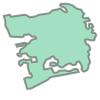

In [35]:
fire_perim_geom_OR4310211883919860320 = mtbs_perim[mtbs_perim.Ig_Date.dt.year == 1986].loc[40, 'geometry']
fire_ig_date_OR4310211883919860320 = mtbs_perim[mtbs_perim.Ig_Date.dt.year == 1986].loc[40, 'Ig_Date']
fire_perim_geom_OR4310211883919860320

In [14]:
# convert the geometry in mtbs_dataset to lat lon
mtbs_dataset = mtbs_dataset.to_crs(epsg=4326)
mtbs_perim = mtbs_perim.to_crs(epsg=4326)

In [28]:
mtbs_perim.dtypes

Event_ID            object
Ig_Date     datetime64[ns]
geometry          geometry
dtype: object

In [51]:
# get a ignition point from a fire in mtbs_dataset
fire_point_geom_OR4310211883919860320= mtbs_dataset.loc[12, 'geometry']
dataset_fire_ig_date_OR4310211883919860320 = mtbs_dataset.loc[12, 'ig_date']

# see if the point is within any perimeter from mtbs_perim
mtbs_perim[(mtbs_perim.geometry.contains(fire_point_geom_OR4310211883919860320)) & (mtbs_perim.Ig_Date == dataset_fire_ig_date_OR4310211883919860320)]

,Event_ID,Ig_Date,geometry
40,OR4310211883919860320,1986-03-20,"POLYGON ((-118.85452 43.11108, -118.85422 43.1..."


In [50]:
print('fire_point_geom {}'.format(fire_point_geom_OR4310211883919860320))
print('fire_perim_geom {}'.format(fire_perim_geom_OR4310211883919860320))
print('dataset_fire_date {}'.format(dataset_fire_ig_date_OR4310211883919860320))
print('perim_fire_date {}'.format(fire_ig_date_OR4310211883919860320))

fire_point_geom POINT (-118.83535049199727 43.11469172335749)
fire_perim_geom POLYGON ((-118.8545232608936 43.111083326592436, -118.85421595259555 43.11036129523316, -118.85245496092314 43.11061786465928, -118.84923604559273 43.111086781136144, -118.84905204596068 43.11102990883012, -118.84865935579052 43.110908532560686, -118.84831440245873 43.110709425118124, -118.84822412121905 43.110657314738845, -118.84804036164601 43.110551247669946, -118.8476487459593 43.11025975637441, -118.8475042984965 43.11017922378669, -118.84679971276861 43.11026194971949, -118.84566641390145 43.11046332956902, -118.84515477606001 43.110596721579846, -118.84466292438906 43.11087527600464, -118.84417160861167 43.111068771567055, -118.84308002206305 43.1112202353989, -118.84190550451984 43.1113864211359, -118.84087596763614 43.11154808149714, -118.84065704747654 43.11162234845591, -118.84048165720071 43.1116818485376, -118.8395633673587 43.112528221005704, -118.83945397930547 43.112629040486794, -118.8382168

In [16]:
# # for each fire in mtbs_perim, find the pixels that intersect with the fire perimeter and set their Fire_ID to the fire's Event_ID, will also have to match on ig_date (mtbs_dataset) and Ig_Date (mtbs_perim)
# for index, row in tqdm.tqdm(mtbs_perim.iterrows(), total=len(mtbs_perim)):
#     fire_id = row.Event_ID
#     fire_geom = row.geometry
#     ig_date = row.Ig_Date
#     print(mtbs_dataset.loc[(mtbs_dataset.geometry.intersects(fire_geom)) & (mtbs_dataset.ig_date == ig_date)])
#     mtbs_dataset.loc[(mtbs_dataset.geometry.intersects(fire_geom)) & (mtbs_dataset.ig_date == ig_date), 'Fire_ID'] = fire_id

# mtbs_dataset
